In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPool2D, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import warnings
import numpy as np
import matplotlib.pyplot as plt

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

# Predicting Uncertaintity by Monte Carlo Dropout

In this section, we establish a way to quantify the uncertainty of predictions. There a different ways to implement uncertaintity estimation, e.g. [*deep ensembles*](https://arxiv.org/pdf/1612.01474.pdf), Monte-Carlo dropout, or *evidence*-based techniques (see [here](https://arxiv.org/abs/1802.10501) or [here](https://arxiv.org/abs/1806.01768?context=cs)). In *deep ensembles* multiple networks are trained and the differences in the predicted probabilities of each network are used to estimate uncertainty. Even though this idea is easy to implement, training multiple networks is a time consuming practice. *Evidence*-based techniques on the other hand are one-shot techniques. However, they are more difficult to implement and train. Furthermore, switching from a classification to a regression task requires significant adaption in implementation. Monte-Carlo dropout requires training of only one model at its implementation straightforward both for classification and regression tasks.  

In this approach, a dropout layer is inserted into the network. Unlike usual dropout layers, this layer is also active during inference and not only during training. By predicting each sample mutliple time with such a network, we effectively mimic a *deep ensemble* while only having to train one single model. See following reference to explore the theory of this idea further: 
- Gal & Ghahramani, [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](http://mlg.eng.cam.ac.uk/yarin/PDFs/NIPS_2015_deep_learning_uncertainty.pdf).

Now we will implement such a CNN network with a Monte-Carlo dropout layer:

In [2]:
class CNNWithUncertaintity(Model):
    def __init__(self, img_w, img_h, img_c, no_classes, dropout_for_uncertainty):
        super(CNNWithUncertaintity, self).__init__()
        self.no_classes = no_classes
        self.model = self.create_model((img_w, img_h, img_c), no_classes, dropout_for_uncertainty)
    
    def create_model(self, input_shape, no_classes, dropout_for_uncertainty):
        inputs = Input(shape=input_shape)
        initializer = tf.keras.initializers.HeNormal(seed=seed)
        x = Conv2D(32, (3, 3), padding="same", activation="relu", kernel_initializer=initializer)(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer=initializer)(x)
        x = GlobalMaxPool2D()(x)
        x = Dropout(0.4)(x, training=False) # only applied during training
        x = Dropout(dropout_for_uncertainty)(x, training=True) # also applied on inference 
        x = Dense(256, activation="relu")(x)
        x = Dense(256, activation="relu")(x)
        outputs = Dense(no_classes, activation="softmax")(x)
        model = Model(inputs=inputs, outputs=outputs)
        return model
    
    
    def call(self, inputs):
        return self.model(inputs)
    
    
    def predict_with_uncertainty(self, X, repeats=30):
        probs = np.zeros((repeats, X.shape[0], self.no_classes))
        for repeat in range(repeats):
            probs[repeat] = self.model.predict(X)

        probs_mean = np.mean(probs, axis=0)
        probs_std = np.std(probs, axis=0)

        pred_classes = np.argmax(probs_mean, axis=1)        
        pred_classes_probs = probs_mean[list(range(len(pred_classes))), pred_classes]
        pred_classes_probs_std = probs_std[list(range(len(pred_classes))), pred_classes]        
        return pred_classes, pred_classes_probs, pred_classes_probs_std

To establish a baseline reference, we will first train a network without Monte-Carlo dropout on 2500 images from the MNIST dataset. Then, we will train a second model with Monte-Carlo dropout. Please note that no rigorous attempts to maximize accuracy are made since this notebook is not about achieving the best accuracy:

In [3]:
(X_all, y_all), (_, _) = tf.keras.datasets.mnist.load_data()
X_all = tf.reshape(X_all, (-1, 28, 28, 1)) / 255
X_train, y_train = X_all[0:2500], y_all[0:2500]
X_validation, y_validation = X_all[2500:5000], y_all[2500:5000]

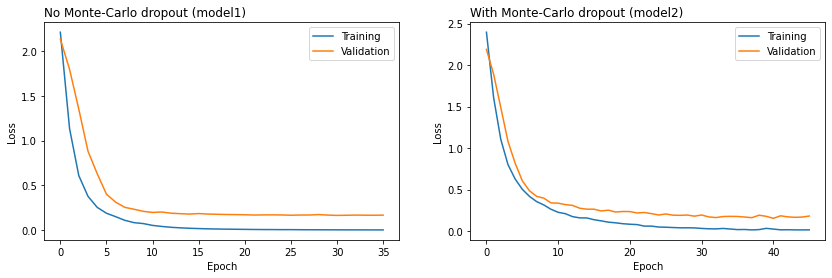

Accuracy for model1 (no Monte-Carlo dropout) on the validation data: 0.954
Accuracy for model2 (with Monte-Carlo dropout) on the validation data: 0.959


In [4]:
model1 = CNNWithUncertaintity(28, 28, 1, 10, dropout_for_uncertainty=0)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=True))
model2 = CNNWithUncertaintity(28, 28, 1, 10, dropout_for_uncertainty=0.1)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=True))

cb1 = callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=5)  

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    history1 = model1.fit(X_train, y_train, epochs=60, batch_size=32,
                          validation_data=(X_validation, y_validation), verbose=0, callbacks=[cb1])
    history2 = model2.fit(X_train, y_train, epochs=60, batch_size=32,
                          validation_data=(X_validation, y_validation), verbose=0, callbacks=[cb1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(history1.history["loss"], label="Training")
ax1.plot(history1.history["val_loss"], label="Validation")
ax1.set_title("No Monte-Carlo dropout (model1)", loc="left")
ax2.plot(history2.history["loss"], label="Training")
ax2.plot(history2.history["val_loss"], label="Validation")
ax2.set_title("With Monte-Carlo dropout (model2)", loc="left")

for axi in [ax1, ax2]:
    axi.set_xlabel("Epoch")
    axi.set_ylabel("Loss")
    axi.legend()
plt.show()

pred_classes1, pred_probs1, _ = model1.predict_with_uncertainty(X_validation, repeats=1)
pred_classes2, pred_probs2, pred_uncertainty2 = model2.predict_with_uncertainty(X_validation)
scorer_accuracy = tf.keras.metrics.Accuracy()
print(f"Accuracy for model1 (no Monte-Carlo dropout) on the validation data: \
{scorer_accuracy(y_validation, pred_classes1).numpy():.3f}")
print(f"Accuracy for model2 (with Monte-Carlo dropout) on the validation data: \
{scorer_accuracy(y_validation, pred_classes2).numpy():.3f}")

Interestingly enough, introduction of the Monte-Carlo dropout layer does not decrease accuracy. This can be mainly explained from the fact that this model is used to make multiple predictions. Therefore, our final prediction comes from an *ensemble* with an overall slightly improved accuracy. But even more interestingly, for the model without Monte-Carlo dropout we can see a well documented phenomen of neural networks: Even when this network makes wrong predictions, it does so with high confidence (high probability). In the right plot however, we can see that the uncertainty estimation from our model with Monte-Carlo dropout is significantly higher for wrong predictions compared to correct predictions:

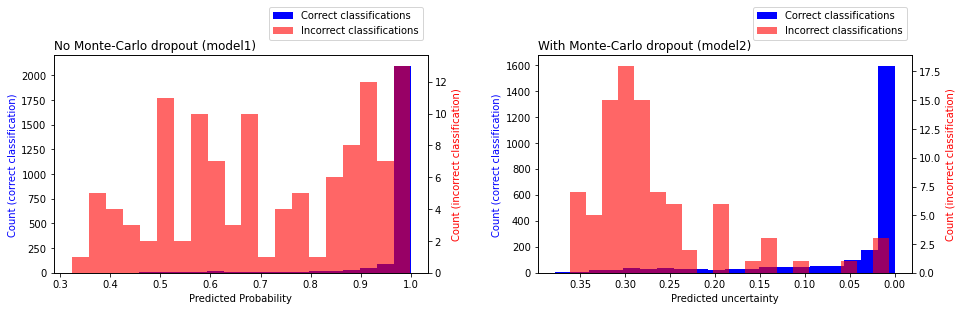

In [5]:
probs1_correct_classifications = pred_probs1[np.where(pred_classes1 == y_validation)[0]]
probs1_incorrect_classifications = pred_probs1[np.where(pred_classes1 != y_validation)[0]]

unc2_correct_classifications = pred_uncertainty2[np.where(pred_classes2 == y_validation)[0]]
unc2_incorrect_classifications = pred_uncertainty2[np.where(pred_classes2 != y_validation)[0]]

fig, (ax1_a, ax2_a) = plt.subplots(1, 2, figsize=(14, 5))
ax1_a.set_xlabel("Predicted Probability")
ax1_a.hist(probs1_correct_classifications, bins=20, alpha=1, color="blue", label="Correct classifications")
ax1_a.set_ylabel("Count (correct classification)", color="blue")
ax1_b = ax1_a.twinx() 
ax1_b.hist(probs1_incorrect_classifications, bins=20, alpha=0.6, color="red", label="Incorrect classifications")
ax1_b.set_ylabel("Count (incorrect classification)", color="red")
ax1_a.set_title("No Monte-Carlo dropout (model1)", loc="left")

ax2_a.set_xlabel("Predicted uncertainty")
ax2_a.hist(unc2_correct_classifications, bins=20, alpha=1, color="blue", label="Correct classifications")
ax2_a.set_ylabel("Count (correct classification)", color="blue")
ax2_a.invert_xaxis()
ax2_b = ax2_a.twinx() 
ax2_b.hist(unc2_incorrect_classifications, bins=20, alpha=0.6, color="red", label="Incorrect classifications")
ax2_b.set_ylabel("Count (incorrect classification)", color="red")
ax2_a.set_title("With Monte-Carlo dropout (model2)", loc="left")

lines, labels = [], []
for axi in [ax1_a, ax1_b]:
    axLine, axLabel = axi.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
ax1_a.legend(lines, labels, loc="lower right", bbox_to_anchor=(0, 1.05, 1, 0.2))
ax2_a.legend(lines, labels, loc="lower right", bbox_to_anchor=(0, 1.05, 1, 0.2))
plt.tight_layout(pad=3.0)
plt.show()